# Prediction du remboursement d'un pret

## Introduction

Lending Club est une société américaine de finance participative. C'est une plateforme de prêt entre particuliers qui permet aux clients emprunteurs d’avoir accès à des crédits à des taux plus bas que ceux proposés par les banques traditionnelles et permet aux clients investisseurs d’investir leurs épargnes sous forme de prêt.

Nous allons dans ce projet exploiter une base de donnée clientèle du Lending Club. Cette base de donnée contient l'ensemble des données relative aux prêts emis à travers la plateforme. L'ensemble des variables observées pour chaque individu sont détaillées dans le dictionnaire.

L'objectif de ce projet est de prédire, à partir de variables pertinentes, si un client emprunteur est susceptible de rembourser ou non son prêt. Pour répondre à cette problématique nous allons utiliser différentes techniques de machine learning. Dans un premier temps nous allons traiter la base de donnée afin qu'elle soit exploitable, en prenant soin de différencier les variables catégorielles des variables numériques. Une partie des observations seront assignées à un dataset d'entraînement ('train_data') et une autre partie à un dataset de test ('test_data').

Puis, après une courte analyse des distributions de régresseurs et de la variable d'intérêt parmis notre sous-population, nous mettrons en place deux modèles prédictifs dont nous analyserons et comparerons les performances : la regression logistique et la classification par forêt d'arbres décisionnels (random forest classifier). Nous avons choisi ces deux modèles car ils semblent être les plus pertinents dans la prédiction d'une variable binaire.

Source de la base donnée : 

https://www.kaggle.com/adarshsng/lending-club-loan-data-csv/version/1?select=loan.csv

In [4]:
import warnings
warnings.filterwarnings('ignore')

## 1.Traitement de la base de donnée

### Exploration des données

In [5]:
import numpy as np
import pandas as pd

data = pd.read_csv("loan.csv")
data.shape

(2260668, 145)

Le dataset contient 2 260 668 individus et 145 colonnes dont la colonne d'intérêt. Nous allons filtrer les colonnes et nous recupererons que les 200 000 premiers individus pour les données d'entrainement et les 10 000 suivant pour les données de test.

Ensuite, étant donné que nous voulons etudier le statut de remboursement des clients, nous allons nous limiter aux catégories suivante de notre variable d'intérêt 'loan_status' :
- Fully Paid : Les personnes qui ont remboursé la totalité de leur crédit.
- Charged Off : Les personnes qui n’ont pas remboursé leur crédit.

Enfin, nous sélectionnons les variables explicatives qui nous semblent pertinentes. 

In [6]:
variables_to_keep = ['loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
                     'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq',
                     'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'emp_length', 'home_ownership', 'purpose',
                     'loan_status']
data_filtered = data[variables_to_keep]
data_filtered = data_filtered[data_filtered['loan_status'].isin(['Charged Off', 'Fully Paid'])]

In [8]:
train_data = data_filtered[:200000]
test_data = data_filtered[200000:210000]

In [9]:
train_data.info() # Affiche les noms des colonnes, le nombre des valeurs manquantes ainsi que leurs types

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 100 to 743954
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   200000 non-null  int64  
 1   annual_inc                  200000 non-null  float64
 2   dti                         199870 non-null  float64
 3   delinq_2yrs                 200000 non-null  float64
 4   inq_last_6mths              200000 non-null  float64
 5   open_acc                    200000 non-null  float64
 6   pub_rec                     200000 non-null  float64
 7   revol_bal                   200000 non-null  int64  
 8   revol_util                  199845 non-null  float64
 9   total_acc                   200000 non-null  float64
 10  collections_12_mths_ex_med  200000 non-null  float64
 11  acc_now_delinq              200000 non-null  float64
 12  tot_coll_amt                200000 non-null  float64
 13  tot_cur_bal 

In [10]:
train_data.isnull().sum(axis = 0) # Comptabilise les valeurs manquantes pour chaque colonne

loan_amnt                         0
annual_inc                        0
dti                             130
delinq_2yrs                       0
inq_last_6mths                    0
open_acc                          0
pub_rec                           0
revol_bal                         0
revol_util                      155
total_acc                         0
collections_12_mths_ex_med        0
acc_now_delinq                    0
tot_coll_amt                      0
tot_cur_bal                       0
total_rev_hi_lim                  0
emp_length                    13573
home_ownership                    0
purpose                           0
loan_status                       0
dtype: int64

In [11]:
#Examinons la variable à prédire
#'Value_count' compte le nombre d'occurences des valeurs d'une colonne 
train_data['loan_status'].value_counts()

Fully Paid     153518
Charged Off     46482
Name: loan_status, dtype: int64

### Preprocessing

Nous allons combiner le train et le test dataset afin que le preprocessing soit appliqué en même temps. L'objectif est de concaténer les 2 fichiers en extrayant au préalable la variable 'loan status' des deux datasets.

In [12]:
def combined_data(train,test):
    target_train = train['loan_status'] # On instancie target_train avec la colonne loan_status du dataset train.
    target_test = test['loan_status'] # On instancie target_test avec la colonne loan_status du dataset test.
    
    # On retire les colonnes de la variable d'intérêt des deux datasets
    train = train.drop('loan_status',axis = 1) 
    test = test.drop('loan_status',axis = 1)
    
    combined = train.append(test) # On concatène le train et le test
    return combined, target_train, target_test

combined, target_train, target_test = combined_data(train_data, test_data)

### Identification des variables catégorielles et numériques

On sépare les variables catégorielles des variables numériques.

In [13]:
numerical_variables = ['loan_amnt','annual_inc','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc','collections_12_mths_ex_med','acc_now_delinq','tot_coll_amt','tot_cur_bal','total_rev_hi_lim']
categorical_variables = ['emp_length','home_ownership','purpose']

### Remplissage de valeurs manquantes

Pour les variables catégorielles, nous allons créer une catégorie 'Unknown'.

In [14]:
combined[categorical_variables] = combined[categorical_variables].fillna('Unknown')

In [15]:
combined[categorical_variables].info() #On voit bien qu'il n'y a plus de valeurs manquantes pour les variables catégorielles

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 100 to 758340
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   emp_length      210000 non-null  object
 1   home_ownership  210000 non-null  object
 2   purpose         210000 non-null  object
dtypes: object(3)
memory usage: 6.4+ MB


Pour les variables continues, nous allons remplacer les NaN par la médiane et créer une variable de contrôle binaire qui vaut 1 
s'il y a une valeur manquante dans la ligne et 0 sinon.

In [16]:
def process_numerical_variables(combined):
    # On crée une colonne missing et on compte le nombre d'occurence des valeurs manquantes dans chaque ligne
    combined['missing'] = combined.isnull().sum(axis = 1) 
    # A partir du résultat obtenu ci-dessus: si la valeur du champs est > 0 alors on complète par 1 sinon on met 0
    combined['missing'] = combined['missing'].apply(lambda x: 1 if x > 0 else 0)
    # On fait une boucle sur numerical_variables puis on remplace la valeur manquante par la mediane
    for feature in numerical_variables :
        median = combined[feature].median()
        combined[feature] = combined[feature].apply(lambda x: median if np.isnan(x) else x)
    return combined

combined = process_numerical_variables(combined)

In [15]:
combined[numerical_variables].info() # On voit qu'il n'y a plus de valeurs manquantes dans les variables numériques

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 100 to 758340
Data columns (total 15 columns):
loan_amnt                     210000 non-null int64
annual_inc                    210000 non-null float64
dti                           210000 non-null float64
delinq_2yrs                   210000 non-null float64
inq_last_6mths                210000 non-null float64
open_acc                      210000 non-null float64
pub_rec                       210000 non-null float64
revol_bal                     210000 non-null int64
revol_util                    210000 non-null float64
total_acc                     210000 non-null float64
collections_12_mths_ex_med    210000 non-null float64
acc_now_delinq                210000 non-null float64
tot_coll_amt                  210000 non-null float64
tot_cur_bal                   210000 non-null float64
total_rev_hi_lim              210000 non-null float64
dtypes: float64(13), int64(2)
memory usage: 25.6 MB


In [17]:
# la colonne missing sert à garder un historique des lignes comportant des valeurs manquantes
combined['missing'].value_counts()

0    209713
1       287
Name: missing, dtype: int64

### One hot encoding (dummification des variables catégorielles)

In [18]:
# on crée des variables type binaire pour chaque catégorie de chaque variable catégorielle: l'objectif est de
# remplacer les chaines de caractère (non interprétable par l'algo) par des variables numériques
# pour faire tourner l'algo
combined = pd.get_dummies(combined, columns = categorical_variables)

In [18]:
combined.info() #on voit ci-dessous la création des variables en question (emp_lenght_1years....)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210000 entries, 100 to 758340
Data columns (total 45 columns):
loan_amnt                     210000 non-null int64
annual_inc                    210000 non-null float64
dti                           210000 non-null float64
delinq_2yrs                   210000 non-null float64
inq_last_6mths                210000 non-null float64
open_acc                      210000 non-null float64
pub_rec                       210000 non-null float64
revol_bal                     210000 non-null int64
revol_util                    210000 non-null float64
total_acc                     210000 non-null float64
collections_12_mths_ex_med    210000 non-null float64
acc_now_delinq                210000 non-null float64
tot_coll_amt                  210000 non-null float64
tot_cur_bal                   210000 non-null float64
total_rev_hi_lim              210000 non-null float64
missing                       210000 non-null int64
emp_length_1 year            

## 2. Statistiques descriptives

### Analyse des variables numériques

Text(0.5, 1.0, 'Distribution de la limite maximale de la valeur du prêt accordée parmis les emprunteurs qui ont remboursé ou pas le prêt')

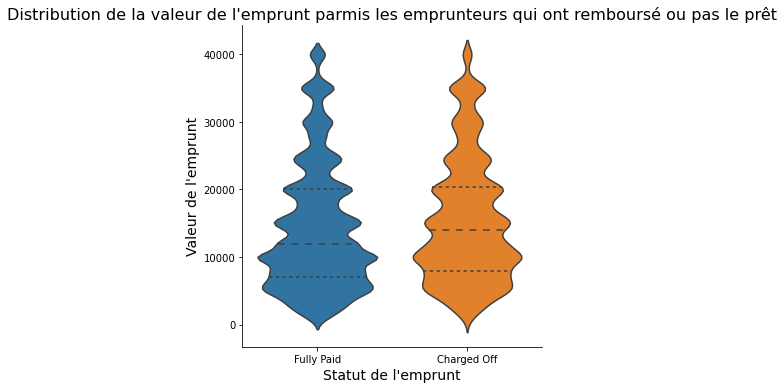

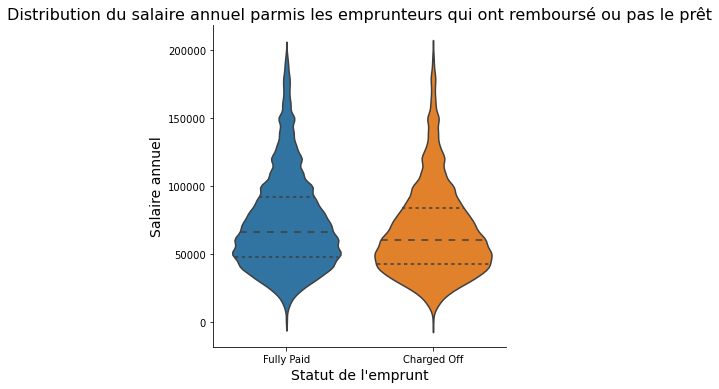

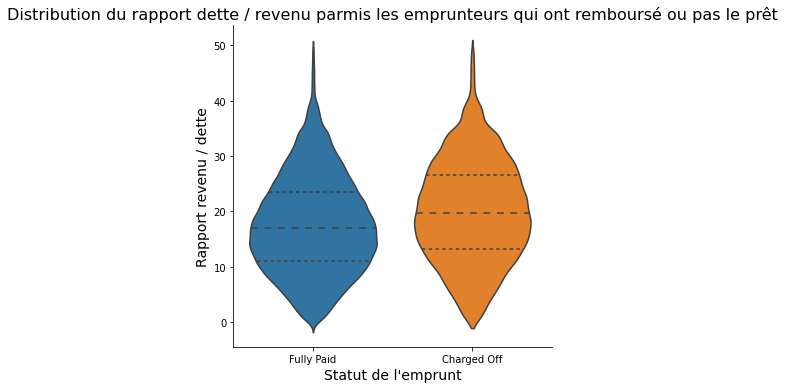

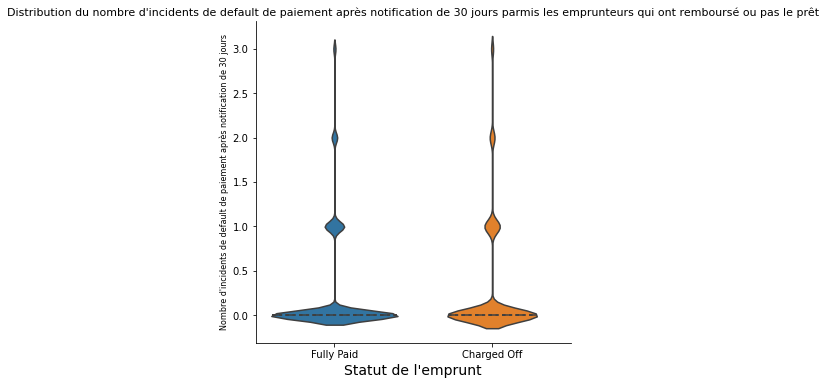

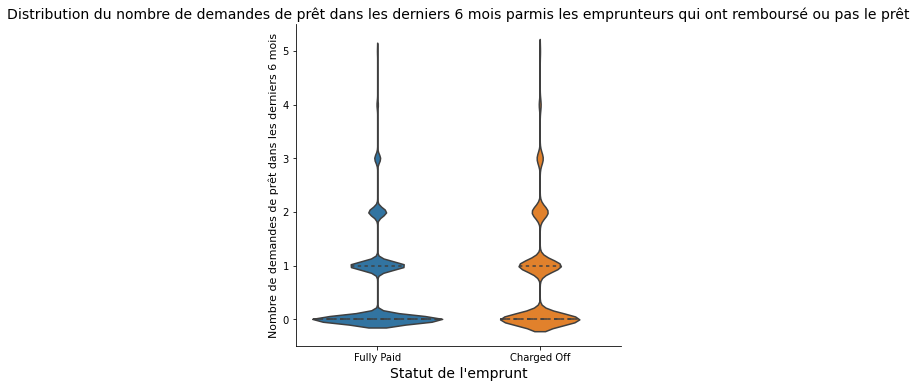

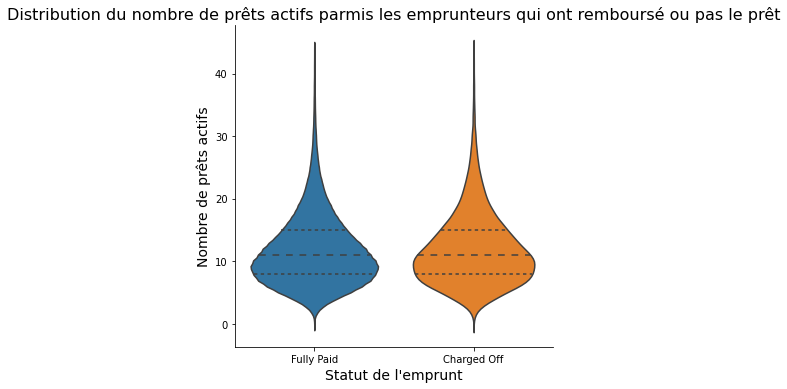

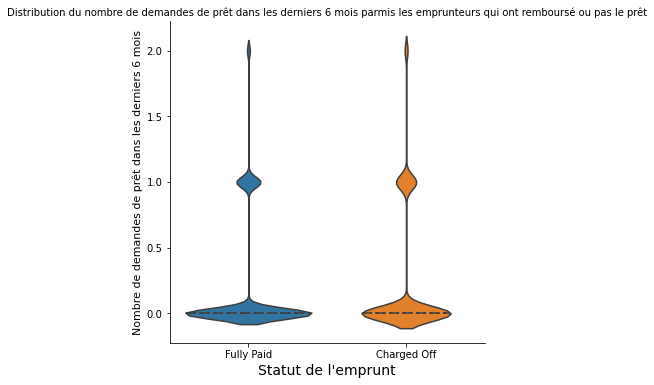

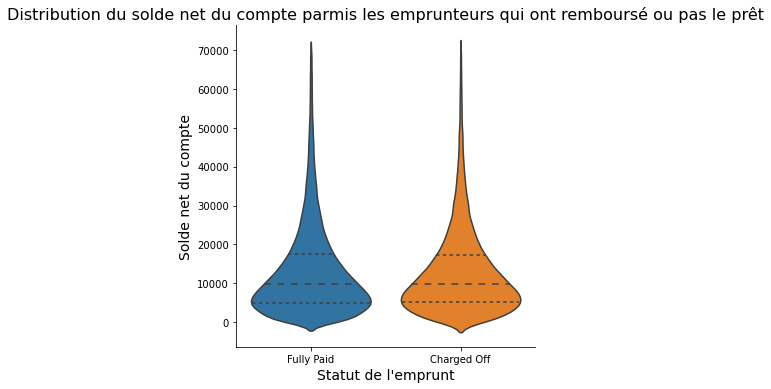

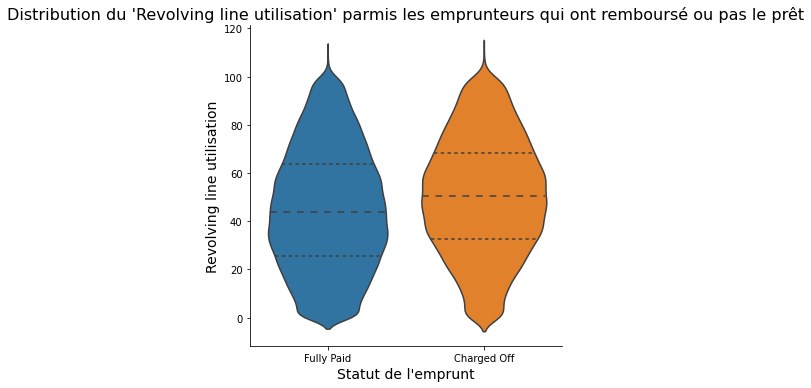

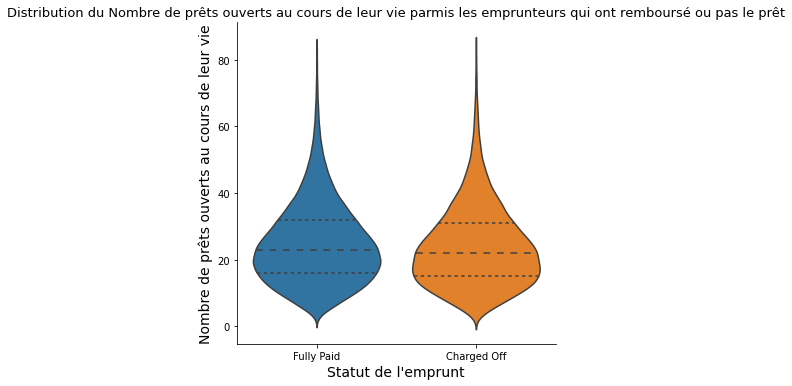

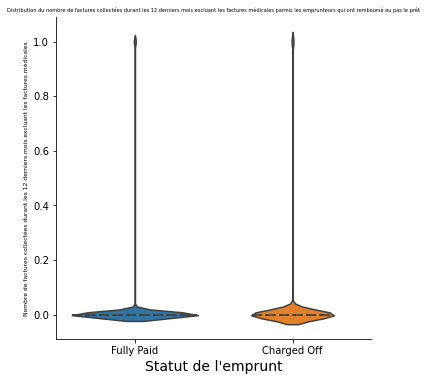

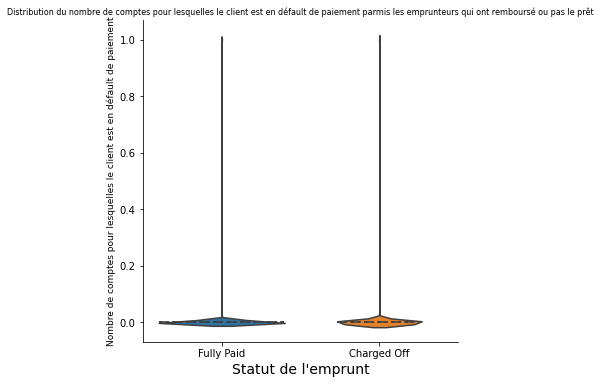

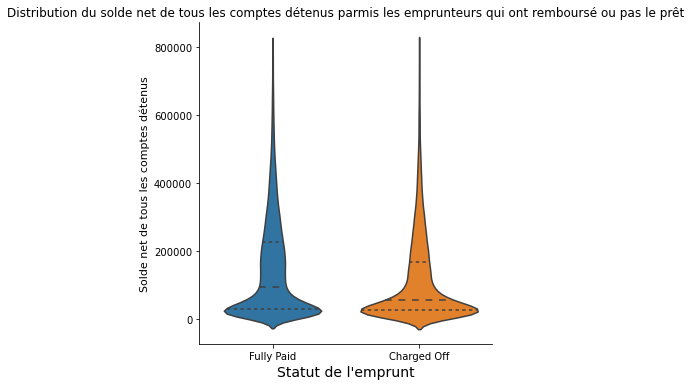

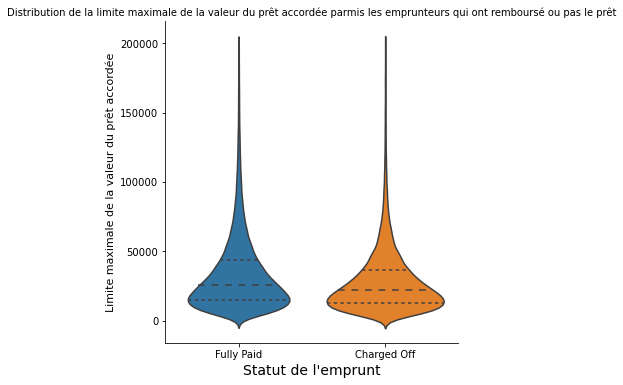

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

# On reprend le dataset train en incluant la colonne de la variable d'intérêt
describe_num_df = data_filtered[:200000]

# On utilise un violin plot pour étudier la distribution des variables numériques 
sns.catplot(x = 'loan_status', y = 'loan_amnt', data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Valeur de l'emprunt", size=14)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution de la valeur de l'emprunt parmis les emprunteurs qui ont remboursé ou pas le prêt", size=16)

# On filtre les valeurs extrêmes
sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['annual_inc'] < 200000]['annual_inc'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Salaire annuel", size=14)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du salaire annuel parmis les emprunteurs qui ont remboursé ou pas le prêt", size=16)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['dti'] < 50]['dti'], data=describe_num_df,  kind = "violin", inner = "quartile", cut = 1)
plt.ylabel("Rapport revenu / dette", size=14)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du rapport dette / revenu parmis les emprunteurs qui ont remboursé ou pas le prêt", size=16)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['delinq_2yrs'] < 4]['delinq_2yrs'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Nombre d'incidents de default de paiement après notification de 30 jours", size=8)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du nombre d'incidents de default de paiement après notification de 30 jours parmis les emprunteurs qui ont remboursé ou pas le prêt", size=11)

sns.catplot(x = 'loan_status', y = 'inq_last_6mths', data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Nombre de demandes de prêt dans les derniers 6 mois", size=11)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du nombre de demandes de prêt dans les derniers 6 mois parmis les emprunteurs qui ont remboursé ou pas le prêt", size=14)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['open_acc'] < 45]['open_acc'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Nombre de prêts actifs", size=14)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du nombre de prêts actifs parmis les emprunteurs qui ont remboursé ou pas le prêt", size=16)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['pub_rec'] < 3]['pub_rec'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Nombre de demandes de prêt dans les derniers 6 mois", size=11)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du nombre de demandes de prêt dans les derniers 6 mois parmis les emprunteurs qui ont remboursé ou pas le prêt", size=10)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['revol_bal'] < 70000]['revol_bal'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Solde net du compte", size=14)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du solde net du compte parmis les emprunteurs qui ont remboursé ou pas le prêt", size=16)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['revol_util'] < 110]['revol_util'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Revolving line utilisation", size=14)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du 'Revolving line utilisation' parmis les emprunteurs qui ont remboursé ou pas le prêt", size=16)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['total_acc'] < 85]['total_acc'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Nombre de prêts ouverts au cours de leur vie", size=14)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du Nombre de prêts ouverts au cours de leur vie parmis les emprunteurs qui ont remboursé ou pas le prêt", size=13)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['collections_12_mths_ex_med'] < 2]['collections_12_mths_ex_med'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Nombre de factures collectées durant les 12 derniers mois excluant les factures médicales", size = 6)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du nombre de factures collectées durant les 12 derniers mois excluant les factures médicales parmis les emprunteurs qui ont remboursé ou pas le prêt", size=5)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['acc_now_delinq'] < 2]['acc_now_delinq'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Nombre de comptes pour lesquelles le client est en défault de paiement", size=9)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du nombre de comptes pour lesquelles le client est en défault de paiement parmis les emprunteurs qui ont remboursé ou pas le prêt", size=8)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['tot_cur_bal'] < 800000]['tot_cur_bal'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Solde net de tous les comptes détenus", size=11)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution du solde net de tous les comptes détenus parmis les emprunteurs qui ont remboursé ou pas le prêt", size=12)

sns.catplot(x = 'loan_status', y = describe_num_df[describe_num_df['total_rev_hi_lim'] < 200000]['total_rev_hi_lim'], data=describe_num_df,  kind = "violin", inner = "quartile")
plt.ylabel("Limite maximale de la valeur du prêt accordée", size=11)
plt.xlabel("Statut de l'emprunt", size=14)
plt.title("Distribution de la limite maximale de la valeur du prêt accordée parmis les emprunteurs qui ont remboursé ou pas le prêt", size=10)


On observe quasiment les mêmes distributions entre les différents types d'emprunteurs. 

L'emprunt médian se situe autours des 12k\\$ et 75\% de ces emprunts ont une valeure inférieure à 20k\\$.

Trois-quart des emprunteurs ont un salaire compris entre 50k\\$ et 100k\\$, ce qui correspond à la 'upper middle class'.

Le rapport revenu/dette est dans 75\% des cas supérieur à 10. Les emprunteurs ne s'endettent que modestement par prêt. Toutefois, le nombre de prêts moyens actifs est au nombre de 10 par client, ce qui semble très élevé. Le nombre de prêts contractés au cours de leur vie est au nombre de 20 en moyenne, ce chiffre est lui aussi élevé. 

Enfin, quasiment tous les clients ont un solde net positif, et le nombre de défaults de paiement reste très bas. 

### Analyse des variables catégorielles

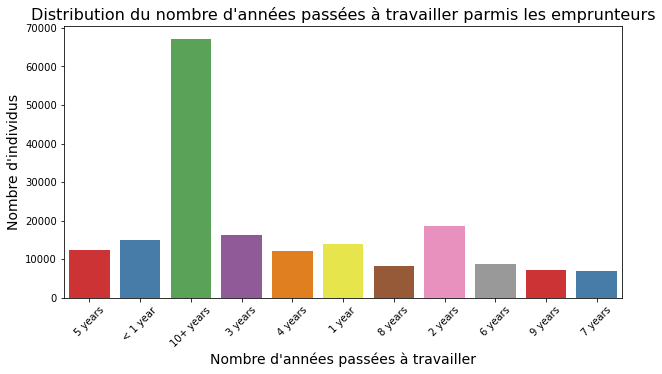

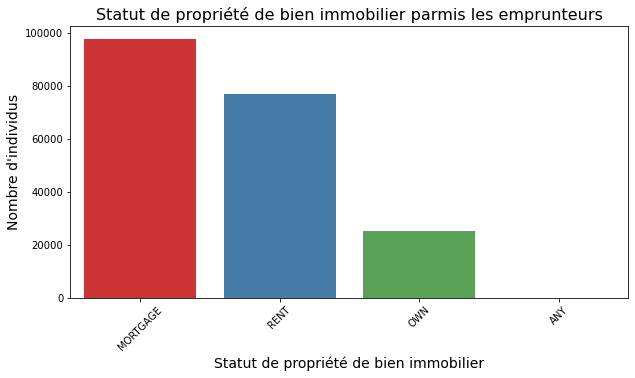

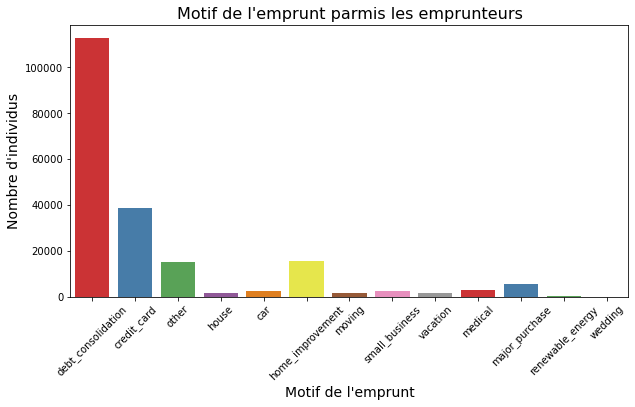

In [144]:
plt.figure(figsize=(10, 5))
chart = sns.countplot(data=train_data, x='emp_length', palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.ylabel("Nombre d'individus", size=14)
plt.xlabel("Nombre d'années passées à travailler", size=14)
plt.title("Distribution du nombre d'années passées à travailler parmis les emprunteurs", size=16)
plt.show()

plt.figure(figsize=(10, 5))
chart = sns.countplot(data=train_data, x='home_ownership', palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.ylabel("Nombre d'individus", size=14)
plt.xlabel("Statut de propriété de bien immobilier", size=14)
plt.title("Statut de propriété de bien immobilier parmis les emprunteurs", size=16)
plt.show()

plt.figure(figsize=(10, 5))
chart = sns.countplot(data=train_data, x='purpose', palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.ylabel("Nombre d'individus", size=14)
plt.xlabel("Motif de l'emprunt", size=14)
plt.title("Motif de l'emprunt parmis les emprunteurs", size=16)
plt.show()

La majorité des emprunteurs ont une expérience professionnelle supérieure à 10 ans. De plus, un tiers des emprunteurs payent un loyer et plus de la moitié des emprunteurs ont contracté un prêt pour l'achat d'un bien immobilier. Enfin, le motif principal d'emprunt correspond au rachat d'un ancien prêt.

## 3. Construction des modèles prédictifs et sélection des hyper-paramètres

Notre base donnée est prête et nous allons maintenant construire les deux modèles prédictifs. L'objectif est de déterminer les 'hyper-paramètres' optimaux de nos deux modèles pour ensuite mesurer leur performances prédictives. Pour déterminer ces paramètres nous ferons usage de la fonction RandomizedSearchCV fournit par la librairie sklearn. L'idée est de lui passer en arguments le type de modélisation choisi, les paramètres et les valeurs correspondantes à optimiser ainsi que la métrique avec laquelle on évalue les performances prédictives de notre modèle et RandomizedSearchCV déterminera les valeurs optimales ainsi que le score associé à ces valeurs pour chacun des modèles. 

In [145]:
# On récupère le train et le test de combined
train = combined[:200000]
test = combined[200000:210000]

In [146]:
# On remplace les chaines de caractères par des valeurs numériques dans target 
# on créé un dictionnaire ci-dessous, 
# où l'on remplace par la valeur 0 le statut du prêt de l'individu lorsqu'il a remboursé son prêt, et par 1 sinon
dic_target = {'Fully Paid' : 0 , 'Charged Off' : 1}

# on parcourt le target et on remplace les clés dans le dictionnaire par la valeur: ex: Fully Paid par 0
target_train = target_train.map(dic_target)
target_test = target_test.map(dic_target)

###  Régression logistique avec régularisation Elastic Net

In [147]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier

In [148]:
# On choisit un modèle de régression logistique 
# régularisé par la méthode elasticnet
# La formulation mathématiques est détaillée ici : 
# https://scikit-learn.org/stable/modules/sgd.html#sgd-mathematical-formulation
estimator = SGDClassifier(loss = 'log', penalty = 'elasticnet')

# Le paramètre l1 ratio nous permet de déterminer une norme pour le terme de régularisation 
# qui est une combinaison convèxe entre la norme l1 et l2. 
# alpha est le paramètre qui va venir multiplier mon terme de régularisation. 
param_grid = {'l1_ratio':[0.5,0.75,1], 'alpha' : [0.001,0.01]}

# Scoring f1 : moyenne harmonique entre la précision et le rappel (recall), où 1 est le meilleur score atteignable et 0 le pire. 
# Précision : metrique qui mesure la précision de l'algorithme à déterminer qu'un échantillon appartienne à la classe positive.
# On note 'true positive' (tp), 'false positive' (fp) et 'false négative' (fn)
# Alors précision = tp/(tp + fp).
# Rappel : metrique qui mesure la proportion  d'échantillons positifs justes trouvés par l'algo 
# parmis l'ensemble des échantillons positifs trouvés par l'algo.
# C'est à dire recall = tp/(tp + fn).
# Formulations mathématiques : https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics


clf = RandomizedSearchCV(estimator = estimator,param_distributions = param_grid,
                         scoring = 'f1')

#Train sont les 'régresseurs' et target_train la variable regressée.
clf.fit(train, target_train)

#best_score_LR est le meilleur f1 obtenu
#best_params_LR sont les paramètres qui maximisent le score f1
best_params_LR , best_score_LR = clf.best_params_ , clf.best_score_

print(best_params_LR,best_score_LR)

{'l1_ratio': 1, 'alpha': 0.01} 0.321654486279614


Le meilleur paramètre pour le 'l1_ratio' est 1 ce qui correspond à la norme l1. 

Le meilleur paramètre pour alpha est 0.01, ce qui est la valeur la plus élevé parmis les valeurs que l'on voulait optimiser. Ceci est logique étant donnée que plus alpha est élevé plus le terme de régularisation sera amplifié dans la fonction du 'regularized training error' que l'on cherche à minimiser. 

Le f1 score correspondant à ces deux paramètres est de 0.322.

### Random Forest Classifier

In [149]:
from sklearn.ensemble import RandomForestClassifier

In [150]:
estimator = RandomForestClassifier()
# n-estimators = Nombre d'arbres dans la forêt
# criterion = critère selon lequel on divise les branches de l'arbre 
# Les deux critères les plus utilisés dans la littérature sont gini et l'entropie. 
param_grid = {'n_estimators' : [100, 200, 300], 'criterion' : ['gini', 'entropy']}

# On utilise le même score employé dans la régression logistique afin de comparer les performances des deux modèles.
clf = RandomizedSearchCV(estimator = estimator, param_distributions = param_grid,
                         scoring = 'f1')

clf.fit(train, target_train)

best_params_RF, best_score_RF = clf.best_params_, clf.best_score_ 

print(best_params_RF, best_score_RF)

{'n_estimators': 100, 'criterion': 'gini'} 0.07713665953742503


Le nombre d'abres opimal dans la forêt est 200, le critère de division des branches optimal est Gini. Avec ces deux paramètres on obtient le f1 score de 0.088.

## 4. Mesure des performances sur les données d'evaluation

In [151]:
from sklearn.metrics import roc_curve,auc,precision_recall_curve,precision_score,recall_score,f1_score

In [157]:
# Régression logistique avec paramètres optimaux
# Relancer l'execution de la cellule si jamais les valeurs obtenus sont plus basses que celles décrites plus bas
LR = SGDClassifier(loss = 'log', penalty = 'elasticnet', l1_ratio = 1, alpha = 0.01)
LR.fit(train, target_train)

# Pour chaque individu dans le dataset test on prédit les probabilités d'appartenance aux deux classes (loan_status : 0 ou 1)
proba_pred_LR = LR.predict_proba(test)

# On crée une nouvelle colonne où l'on attribue à chaque observation 1 aux observations 
# dont la probabilité d'apartenir à la classe positive 
# dépasse le seuil d'équiprobabilité de 0.5, 0 sinon. 
pred_LR = proba_pred_LR[:, 1] > 0.5

# On mesure la précision, le recall et le score f1 de nos prédictions. 
prec_score_LR = precision_score(target_test, pred_LR)
rec_score_LR = recall_score(target_test, pred_LR)
f1_score_LR = f1_score(target_test, pred_LR)

# Dans l'ordre sont affichés la précision, le recall et le f1 score associés à notre prédiction
print(prec_score_LR, rec_score_LR, f1_score_LR)

0.2679099678456592 0.8686405337781484 0.40951538385923525


In [153]:
# On répète le même processus avec la Random Forest
RF = RandomForestClassifier(n_estimators = 200, criterion = 'gini')
RF.fit(train, target_train)

proba_pred_RF = RF.predict_proba(test)
pred_RF = proba_pred_RF[:, 1] > 0.5

prec_score_RF = precision_score(target_test, pred_RF)
rec_score_RF = recall_score(target_test, pred_RF)
f1_score_RF = f1_score(target_test, pred_RF)
print(prec_score_RF, rec_score_RF, f1_score_RF)

0.52 0.048790658882402 0.08921082729698818


Même si la précision est plus élevé pour la Random Forest, la régression logistique obtient un recall 17 fois plus élevé, et un f1 score 5 fois plus grand.

### Courbes ROC et Precision-Recall

Afin de mesurer et visualiser les performances de prédiction de nos différents modèles nous allons calculer les courbes ROC (Receiver Operating Characteristic curve) et Precision-Recall. 

La courbe ROC trace l'ensemble des points (fpr, tpr) à mesure que l'on varie le seuil de discrimination dans [0, 1] (voir commentaires plus bas). Le point en haut à droite représente un classificateur parfait pour lequelle le taux de vrais positifs est maximal et le taux de faux négatifs nul.

La courbe Précision-Rappel sert à mesurer la performance d’un classificateur binaire également. C’est un graphique qui représente la précision par rapport au rappel pour une série de valeurs seuils. 

Cette courbe évalue le compromis entre la précision et le rappel. Le point en haut à droite représente un classificateur parfait pour lequel les deux taux sont égaux à 100%.

In [158]:
from matplotlib import pyplot as plt

In [159]:
# fpr = false positive rate = fréquence de faux positifs = fp/(tp + fp) , tpr = true positive rate = precision
# thresholds_lr = seuil de probabilité pour chaque individu à partir du quel 
# on considère qu'il appartienne à la classe positive, aussi appelé seuil de discriminination. 

# Fonction roc_curve prend comme argument les vrais valeurs de la variable d'intérêt du dataset test, soit 'target_test';
# Les valeurs prédites par la régression logistique pour la variable d'intérêt dans le dataset_test, soit 'pred_LR';
# et output l'ensemble des points (fpr, tpr) associés à chaque valeur du seuil de discrimination. 
fpr_LR, tpr_LR, thresholds_LR = roc_curve(target_test, pred_LR, pos_label = 1)


precision_LR, recall_LR, thresholds_LR = precision_recall_curve(target_test, pred_LR, pos_label = 1)

# AUC calcule l'aire sous la courbe.
# Plus l'aire sous la courbe est élevé, meilleur est la prédiction
roc_auc_LR = auc(fpr_LR, tpr_LR)
PR_auc_LR = auc(recall_LR, precision_LR)

In [160]:
# On répète le même processus pour le Random Forest Classifier
fpr_RF, tpr_RF, thresholds_RF = roc_curve(target_test, pred_RF, pos_label = 1)
precision_RF, recall_RF, thresholds_RF = precision_recall_curve(target_test, pred_RF, pos_label = 1)
roc_auc_RF = auc(fpr_RF, tpr_RF)
PR_auc_RF = auc(recall_RF, precision_RF)

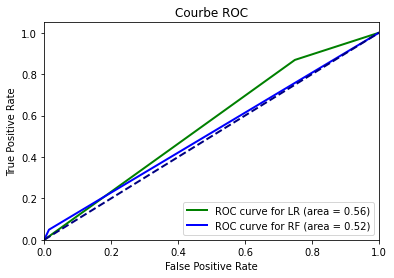

In [161]:
# On graphe les deux courbes pour les deux modèles
plt.figure()
lw = 2
plt.plot(fpr_LR, tpr_LR, color='green',
         lw=lw, label='ROC curve for LR (area = %0.2f)' % roc_auc_LR)
plt.plot(fpr_RF, tpr_RF, color='blue',
         lw=lw, label='ROC curve for RF (area = %0.2f)' % roc_auc_RF)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

Pour l'ensemble des valeurs seuils, la regression logistique obtient de meilleurs couples (fpr,tpr) que la random forest classifier. C'est pourquoi l'aire sous la courbe ROC est supérieure pour le modèle à regression logistique que pour le modèle à classificateur d'arbres décisionnels. 

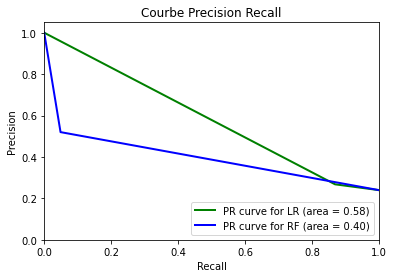

In [164]:
plt.figure()
lw = 2
plt.plot(recall_LR,precision_LR, color='green',
         lw=lw, label='PR curve for LR (area = %0.2f)' % PR_auc_LR)
plt.plot(recall_RF,precision_RF, color='blue',
         lw=lw, label='PR curve for RF (area = %0.2f)' % PR_auc_RF)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision Recall')
plt.legend(loc="lower right")
plt.show()

Le résultat pour la courbe Precision Recall est plus mitigé. En effet la régression logistique rèste meilleure pour des valeurs seuils inférieures à 0.85, mais le classificateur d'arbres décisionels semble légèrement meilleur pour des valeurs seuils supérieurs à 0.85. Toutefois, l'aire sous la courbe est de 0.58 pour la regression logistique contre 0.40 pour la Random Forest. On peut donc encore une fois dire que la regression logistique reste meilleur à prédire la variable d'intérêt. 

## 5. L'importance des variables

L'étude de l'importance des variables est une tâche importante, car d'une part, nous voulons connaitre les variables qui sont pertinentes pour la prédiction et, d'autre part, cela nous offre la possibilité de ne conserver que les variables les mieux classées.

In [165]:
from sklearn import preprocessing

# LabelEncoder permet de transformer nos variables catégorielles en des variables numériques.
# A la différence du one hot encoding, cette méthode ne crée pas autant de variable binaires que de 
# catégories. Elle permet de transformer catégorielle d'origine en une variable numérique
# contenant des indices associés à chaque catégorie.
le = preprocessing.LabelEncoder()

# On copie le train dataset
train2 = train_data.copy()

# On enlève la colonne 'loan_status'
train2 = train2.drop(['loan_status'],axis=1)

# On transforme la colonne emp_length en chaine de caractères (sinon erreur)
train2['emp_length'] = train2['emp_length'].astype(str)

# On applique le labelEncoder sur les variables catégorielles
train2[categorical_variables] = train2[categorical_variables].apply(le.fit_transform)

# On remplace les valeurs manquantes par -1. 
train2 = train2.fillna(-1)

In [166]:
# Nous importons le module RFE de la librairie sklearn : Recursive Feature Elimination
# C'est une méthode qui va commencer avec le jeu de donnée complet et au fur et à mesure
# va venir écarter la variable la moins importante.
from sklearn.feature_selection import RFE

# On applique le RFE sur la régression logistique, notre modèle optimal
LR = SGDClassifier(loss = 'log', penalty = 'elasticnet', l1_ratio = 1, alpha = 0.01)

RFE_ = RFE(LR, n_features_to_select = 1)
RFE_.fit(train2, target_train)

ranking = RFE_.ranking_
names = list(train2)

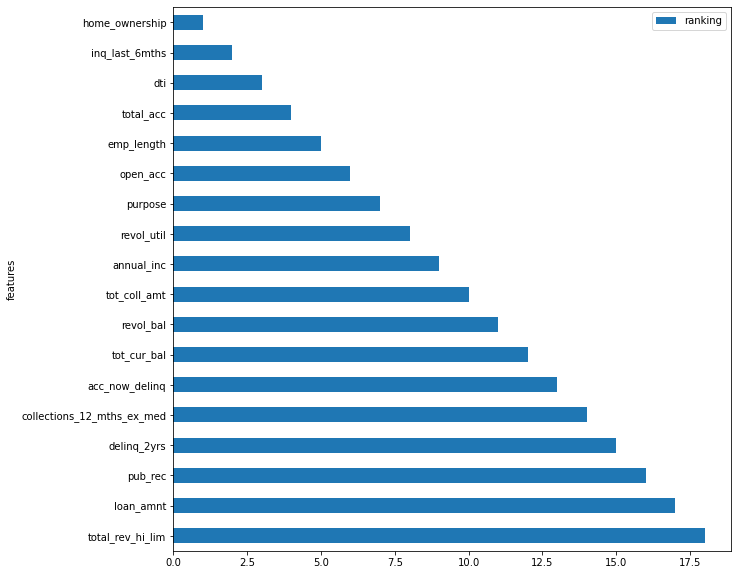

In [167]:
# Cellule d'affichage de l'histogramme du classement dans l'ordre croissant.
importance_RFE = dict(sorted(zip(names, ranking),key = lambda x: x[1]))

df = pd.DataFrame()
df['features'] = importance_RFE.keys()
df['ranking'] = importance_RFE.values()
df.set_index('features', inplace=True)
df.sort_values(by=['ranking'], ascending=False, inplace=True)

df.plot(kind='barh', figsize=(10, 10))
plt.show()

Dans l'ordre de pertinence nous trouvons les variables explicatives suivante dans le top 7: 
- Propriété de bien immobilier
- Rapport revenu / dette
- Motif d'emprunt

La considération de ces 3 variables est tout à fait légitime et coincide avec les informations utilisées par les services d'évaluation de risque des banques. 

## Conclusion

A partir des tests des différents modèles, nous avons conclu que la meilleure stratégie est de choisir la regression logistique comme classificateur binaire. De plus, nous avons déterminé que le classement par ordre de pertinence des différentes variables explicatives utilisées dans notre modélisation semble concorder avce les données empiriques. 